In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import statsmodels.api as sm

from datetime import datetime
from IPython.display import display
from itertools import combinations
from matplotlib.ticker import MaxNLocator
from numpy.testing import assert_almost_equal
from sklearn.decomposition import PCA
from statsmodels.stats.proportion import proportions_ztest

# Custom output options.
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.precision', 3)

%matplotlib inline

CRYPTO_FILES = [('ripple_price', 'rip'), ('bitcoin_price', 'btc'),
                ('ethereum_price', 'eth'), ('litecoin_price', 'ltc'),
                ('monero_price', 'mon'), ('nem_price', 'nem'),
                ('dash_price', 'dash')]

XLE_FILES = [('COP_data', 'COP'), ('CVX_data', 'CVX'),
                ('EOG_data', 'EOG'), ('OXY_data', 'OXY'),
                ('PSX_data', 'PSX'), ('SLB_data', 'SLB'),
                ('XOM_data', 'XOM')]

In [2]:
def load_returns_matrix (files, tdelta=pd.Timedelta(days=30), center=True, 
                         scale=True):
    """Returns cryptocurrency rolling returns in three formats for which 
    a price level is available for all the assets.
    
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_adj (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
        xout (np.matrix): Returns matrix with centering/scaling (depending 
            on args), i.e., without index or column names.
    """
    dfs = []
    for file, name in files:
        path = 'cryptocurrencypricehistory//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['Date', 'Close'])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', 'Close']]
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    first_date = min(dfout.index)
    last_date = max(dfout.index)
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_adj = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_adj, np.matrix(xout)


def load_xle_returns (files, tdelta=pd.Timedelta(days=30), center=True, 
                      scale=True):
    """Returns top XLE components' rolling returns in three formats.
        
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_adj (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
        xout (np.matrix): Returns matrix with centering/scaling (depending 
            on args), i.e., without index or column names.
    """
    dfs = []
    for file, name in files:
        path = 'XLE//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['Date', 'Close']).iloc[::-1]
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', 'Close']]
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_adj = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_adj, np.matrix(xout)

def create_proportion_of_variation_df (eigvals):
    total_var = sum(eigvals)
    cols = ['component', 'eigenvalue', 'proportion', 'cumulative']
    df = pd.DataFrame(columns=cols)
    cum = 0
    for i, e in enumerate(eigvals):
        cum += e
        row = {'component':i + 1,
               'eigenvalue':e,
               'proportion':e/total_var,
               'cumulative':cum/total_var}
        df = df.append(row, ignore_index=True)
    df['component'] = df['component'].astype(int)
    df.set_index('component', drop=True, inplace=True)
    return df


def create_eigvec_df (eigvecs):
    """Create DataFrame of eigenvectors."""
    idx = [i + 1 for i in range(len(eigvecs))]
    df = pd.DataFrame(index=idx)
    for i, v in enumerate(eigvecs):
        df['V{}'.format(i + 1)] = v
    return df

## Cryptocurrency returns analysis

In [3]:
# Init data and obtain covariance matrix.
cryp_unadj, cryp_std, Xcryp = load_returns_matrix(CRYPTO_FILES,
                                                  center=True, 
                                                  scale=True)

analysis_start_dt = min(cryp_std.index)
analysis_end_dt = max(cryp_std.index)

n, p = Xcryp.shape
C = np.cov(Xcryp, rowvar=False)  # covariance matrix
assert n == len(cryp_std.index)
print('Number of returns in data: {}'.format(n))
print('Analysis start date: {}'.format(analysis_start_dt))
print('Analysis end date: {}'.format(analysis_end_dt))

Number of returns in data: 794
Analysis start date: 2015-09-06 00:00:00
Analysis end date: 2017-11-07 00:00:00


In [4]:
from numpy import array,identity,diagonal
from math import sqrt

def jacobi(A,tol = 1.0e-9): # Jacobi method

    # Finds largest element and its indexes below the diagonal:
    def getMax(A):
        maxVal = 0.0
	# Only need to check lower triangle of matrix:
        for i in range(len(A)-1):
            for j in range(i+1,len(A)):
                if abs(A[i,j]) >= maxVal:
                    maxVal,k,l = abs(A[i,j]),i,j
        return maxVal,k,l

    # Performs one plane rotation to eliminate the largest element
    # that is not on the diagonal.
    # Input:
    # A: square matrix that is initially the covariance matrix
    # P: the eigenvector matrix that is initally the identity matrix
    # 
    # Output (does not return the variables, changes by reference):
    # A: has the eigenvalues on the diagonal
    # P: stores the eigenvectors
    # rotCount: stores how many rotations were performed:
    def rotate(A,P,rotCount):

        # Performs a rotation at locations (i,j) and (k,l) in matrix M:
        # M : the matrix to perform rotation on
        # i,j: location of first element to rotate
        # k,l: location of second element to rotate
        def rotatePair(M,i,j,k,l):
            M_ij,M_kl = M[i,j],M[k,l]
        
            M[i,j] = M_ij - s*(M_kl+M_ij*tau)
            M[k,l] = M_kl + s*(M_ij-M_kl*tau)
        
        # Size of matrix:
        n = len(A)

        # Get indexes of max element:  
        maxVal,i,j = getMax(A)

        # Matrix has converged if the maximum non-diagonal value is less than epsilon
        # If we have performed 5*n^2 rotations and the matrix has not converged we return:
        if maxVal < tol or rotCount==5*n**2: return

        # Variables used for rotation:
        theta = (A[j,j]-A[i,i])/(2*A[i,j])
        t = np.sign(theta)/(abs(theta) + sqrt(theta**2 + 1.0))
        c = 1.0/sqrt(1.0 + t**2);
        s = t*c
        tau = s/(1.0 + c)

        # Rotation point and it's projection points on the diagonal:
        A_ij = A[i,j]

        # Case i)
        A[i,j] = 0.0
        
        # Case ii)
        A[i,i] = A[i,i]-t*A_ij
        A[j,j] = A[j,j]+t*A_ij

        # Case iii)
        # Rotation of elements:
        # Combines 3 cases of rotations (see picture TODO:):
        # i)   r < i
        # ii)  i < r < j
        # iii) j < r
        
        for r in range(i):
            rotatePair(A,r,i,r,j)
        for r in range(i+1,j):
            rotatePair(A,i,r,r,j)
        for r in range(j+1,n):
            rotatePair(A,i,r,j,r)
        
        # Update eigenvector matrix:
        for r in range(n):
            rotatePair(P,r,i,r,j)
        
        # Iterate until matrix converges:
        rotate(A,P,rotCount+1)

    # Initialize the eigenvector matrix:
    n,P,rotCount = len(A),identity(len(A))*1.0,0

    # Rotate until the matrix has converged:
    rotate(A,P,rotCount)

    if rotCount == 5*n**2:
        print('The Jacobi method did not converge')

    return diagonal(A),P


In [5]:


from copy import deepcopy
# Jacobi method
# Performs a series of plane rotations to calculate eigenvalues and
# eigenvectors of a matrix, A. Iteratively finds the largest element
# and makes it zero by performing a plane rotation on the rows and columns
# where the largest element is located.
#
# Return:
# Returns eigenvalues for matrix A and the corresponding eigenvectors.
def jacobi(A,tol = 1.0e-9): # Jacobi method

    # Sorts the eigenvalues and keeps the order of the corresponding
    # eigenvectors.
    def sortResults(values,vectors):
        vectors = vectors.T
        
        indexes = list(reversed(np.argsort(values)))
        print("indexes=",indexes)
        values = sorted(values,reverse=True)
        
        temp = deepcopy(vectors)
        
        for i in range(len(vectors)):
            print("i=",i)
            print(vectors)
            vectors[i][:] = temp[indexes[i]][:]
        
        return (values,vectors)

    # Finds largest element and its indexes above the diagonal:
    def getMax(A):
        maxVal = 0.0
        # Only need to check upper triangle of matrix:
        for i in range(len(A)-1):
            for j in range(i+1,len(A)):
                if abs(A[i,j]) >= maxVal:
                    maxVal,k,l = abs(A[i,j]),i,j
        return maxVal,k,l

    # Performs one plane rotation to eliminate the largest element
    # that is not on the diagonal.
    # Input:
    # A: square matrix that is initially the covariance matrix
    # P: the eigenvector matrix that is initally the identity matrix
    # 
    # Output (does not return the variables; changes by reference):
    # A: has the eigenvalues on the diagonal
    # P: stores the eigenvectors
    # rotCount: stores how many rotations were performed:
    def rotate(A,P,rotCount):

        # Performs a rotation at locations (i,j) and (k,l) in matrix M:
        # M : the matrix to perform rotation on
        # i,j: location of first element to rotate
        # k,l: location of second element to rotate
        def rotatePair(M,i,j,k,l):
            M_ij,M_kl = M[i,j],M[k,l]
        
            M[i,j] = M_ij - s*(M_kl+M_ij*tau)
            M[k,l] = M_kl + s*(M_ij-M_kl*tau)
        
        # Size of matrix:
        n = len(A)

        # Get indexes of max element:  
        maxVal,i,j = getMax(A)

        # Matrix has converged if the maximum non-diagonal value is less than epsilon
        # If we have performed 5*n^2 rotations and the matrix has not converged we return:
        if maxVal < tol or rotCount==5*n**2:
            return

        # Variables used for rotation:
        theta = (A[j,j]-A[i,i])/(2*A[i,j])
        t = np.sign(theta)/(abs(theta) + sqrt(theta**2 + 1.0))
        c = 1.0/sqrt(1.0 + t**2);
        s = t*c
        tau = s/(1.0 + c)

        # Rotation point and it's projection points on the diagonal:
        A_ij = A[i,j]

        # Case i)
        A[i,j] = 0.0
        
        # Case ii)
        A[i,i] = A[i,i]-t*A_ij
        A[j,j] = A[j,j]+t*A_ij

        # Case iii)
        # Rotation of elements:
        # Combines types of rotations (see picture in PDF):
        
        for r in range(i): # i)   r < i
            rotatePair(A,r,i,r,j)
        for r in range(i+1,j): # ii)  i < r < j
            rotatePair(A,i,r,r,j)
        for r in range(j+1,n): # iii) j < r
            rotatePair(A,i,r,j,r)
        
        # Update eigenvector matrix:
        for r in range(n):
            rotatePair(P,r,i,r,j)
        
        # Iterate until matrix converges:
        rotate(A,P,rotCount+1)

    # Initialize the eigenvector matrix:
    n,P,rotCount = len(A),identity(len(A))*1.0,0

    # Rotate until the matrix has converged:
    rotate(A,P,rotCount)

    if rotCount == 5*n**2:
        print('The Jacobi method did not converge')

    A,P = sortResults(diagonal(A),P)
    return A,P

cov = np.cov(Xcryp, rowvar=False)

values,vectors = jacobi(cov,tol = 1.0e-9)
print(values)
print(vectors)

indexes= [3, 6, 4, 1, 5, 2, 0]
i= 0
[[ 0.764  0.091 -0.118 -0.511  0.012 -0.351  0.103]
 [-0.286  0.867  0.007 -0.226 -0.311 -0.044  0.13 ]
 [ 0.013  0.064  0.712  0.087 -0.027 -0.472 -0.508]
 [ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.105  0.305 -0.204 -0.065  0.88  -0.037 -0.274]
 [-0.015 -0.095  0.228 -0.611 -0.056  0.64  -0.39 ]
 [-0.237 -0.15   0.508 -0.309  0.327 -0.063  0.676]]
i= 1
[[ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.286  0.867  0.007 -0.226 -0.311 -0.044  0.13 ]
 [ 0.013  0.064  0.712  0.087 -0.027 -0.472 -0.508]
 [ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.105  0.305 -0.204 -0.065  0.88  -0.037 -0.274]
 [-0.015 -0.095  0.228 -0.611 -0.056  0.64  -0.39 ]
 [-0.237 -0.15   0.508 -0.309  0.327 -0.063  0.676]]
i= 2
[[ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.237 -0.15   0.508 -0.309  0.327 -0.063  0.676]
 [ 0.013  0.064  0.712  0.087 -0.027 -0.472 -0.508]
 [ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.105  0.305 

In [6]:
from copy import deepcopy
# Jacobi method
# Performs a series of plane rotations to calculate eigenvalues and
# eigenvectors of a matrix, A. Iteratively finds the largest element
# and makes it zero by performing a plane rotation on the rows and columns
# where the largest element is located.
#
# Return:
# Returns eigenvalues for matrix A and the corresponding eigenvectors.
def jacobi(A,tol = 1.0e-9): # Jacobi method

    # Sorts the eigenvalues and keeps the order of the corresponding
    # eigenvectors.
    # Output:
    # Eigenvalues in sorted order
    # Eigenvectors in corresponding order
    def sortResults(values,vectors):
        # Column vectors represent the eigenvectors:
        vectors = vectors.T
        
        indexes = list(reversed(np.argsort(values)))

        values = sorted(values,reverse=True)
        
        temp = deepcopy(vectors)
        
        for i in range(len(vectors)):
            vectors[i][:] = temp[indexes[i]][:]
        
        return (values,vectors)

    # Finds largest element and its indexes above the diagonal:
    def getMax(A):
        maxVal = 0.0
        # Only need to check upper triangle of matrix:
        for i in range(len(A)-1):
            for j in range(i+1,len(A)):
                if abs(A[i,j]) >= maxVal:
                    maxVal,k,l = abs(A[i,j]),i,j
        return maxVal,k,l

    # Performs one plane rotation to eliminate the largest element
    # that is not on the diagonal.
    # Input:
    # A: square matrix that is initially the covariance matrix
    # P: the eigenvector matrix that is initally the identity matrix
    # 
    # Output (does not return the variables; changes by reference):
    # A: has the eigenvalues on the diagonal
    # P: stores the eigenvectors
    # rotCount: stores how many rotations were performed:
    def rotate(A,P,rotCount):

        # Performs a rotation at locations (i,j) and (k,l) in matrix M:
        # M : the matrix to perform rotation on
        # i,j: location of first element to rotate
        # k,l: location of second element to rotate
        def rotatePair(M,i,j,k,l):
            M_ij,M_kl = M[i,j],M[k,l]
        
            M[i,j] = M_ij - s*(M_kl+M_ij*tau)
            M[k,l] = M_kl + s*(M_ij-M_kl*tau)
        
        # Size of matrix:
        n = len(A)

        # Get indexes of max element:  
        maxVal,i,j = getMax(A)

        # Matrix has converged if the maximum non-diagonal value is less than epsilon
        # If we have performed 5*n^2 rotations and the matrix has not converged we return:
        if maxVal < tol or rotCount==5*n**2:
            A,P = sortResults(diagonal(A),P)
            return

        # Variables used for rotation:
        theta = (A[j,j]-A[i,i])/(2*A[i,j])
        t = np.sign(theta)/(abs(theta) + sqrt(theta**2 + 1.0))
        c = 1.0/sqrt(1.0 + t**2);
        s = t*c
        tau = s/(1.0 + c)

        # Rotation point and it's projection points on the diagonal:
        A_ij = A[i,j]

        # Case i)
        A[i,j] = 0.0
        
        # Case ii)
        A[i,i] = A[i,i]-t*A_ij
        A[j,j] = A[j,j]+t*A_ij

        # Case iii)
        # Rotation of elements:
        # Combines types of rotations (see picture in PDF):
        
        for r in range(i): # i)   r < i
            rotatePair(A,r,i,r,j)
        for r in range(i+1,j): # ii)  i < r < j
            rotatePair(A,i,r,r,j)
        for r in range(j+1,n): # iii) j < r
            rotatePair(A,i,r,j,r)
        
        # Update eigenvector matrix:
        for r in range(n):
            rotatePair(P,r,i,r,j)
        
        # Iterate until matrix converges:
        rotate(A,P,rotCount+1)

    # Initialize the eigenvector matrix:
    n,P,rotCount = len(A),identity(len(A))*1.0,0

    # Rotate until the matrix has converged:
    rotate(A,P,rotCount)

    if rotCount == 5*n**2:
        print('The Jacobi method did not converge')

    A,P = sortResults(diagonal(A),P)
    return A,P

cov = np.cov(Xcryp, rowvar=False)

values,vectors = jacobi(cov,tol = 1.0e-9)
print(values)
print(vectors)

[2.6573777970786576, 1.3761939225744024, 0.94070625242644068, 0.76868538699591182, 0.56351198020471571, 0.46350355182270092, 0.23884834723260506]
[[-0.286  0.867  0.007 -0.226 -0.311 -0.044  0.13 ]
 [ 0.764  0.091 -0.118 -0.511  0.012 -0.351  0.103]
 [-0.015 -0.095  0.228 -0.611 -0.056  0.64  -0.39 ]
 [-0.237 -0.15   0.508 -0.309  0.327 -0.063  0.676]
 [ 0.013  0.064  0.712  0.087 -0.027 -0.472 -0.508]
 [-0.105  0.305 -0.204 -0.065  0.88  -0.037 -0.274]
 [ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]]


In [7]:
def jacobi(A,tol = 1.0e-9): # Jacobi method
    
    # Sorts the eigenvalues and keeps the order of the corresponding
    # eigenvectors.
    def sortResults(values,vectors):
        vectors = vectors.T
        
        indexes = list(reversed(np.argsort(values)))
        print(values)
        print("indexes=",indexes)
        values = sorted(values,reverse=True)
        
        temp = deepcopy(vectors)
        
        for i in range(len(vectors)):
            print("i=",i)
            print(vectors)
            vectors[i][:] = temp[indexes[i]][:]
        
        return (values,vectors)
    
    # Finds largest element and its indexes above the diagonal:
    def getMax(A):
        maxVal = 0.0
        # Only need to check upper triangle of matrix:
        for i in range(len(A)-1):
            for j in range(i+1,len(A)):
                if abs(A[i,j]) >= maxVal:
                    maxVal,k,l = abs(A[i,j]),i,j
        return maxVal,k,l
    
    # Performs one plane rotation to eliminate the largest element
    # that is not on the diagonal.
    # Input:
    # A: square matrix that is initially the covariance matrix
    # P: the eigenvector matrix that is initally the identity matrix
    #
    # Output (does not return the variables; changes by reference):
    # A: has the eigenvalues on the diagonal
    # P: stores the eigenvectors
    # rotCount: stores how many rotations were performed:
    def rotate(A,P,rotCount):
        
        # Performs a rotation at locations (i,j) and (k,l) in matrix M:
        # M : the matrix to perform rotation on
        # i,j: location of first element to rotate
        # k,l: location of second element to rotate
        def rotatePair(M,i,j,k,l):
            M_ij,M_kl = M[i,j],M[k,l]
            
            M[i,j] = M_ij - s*(M_kl+M_ij*tau)
            M[k,l] = M_kl + s*(M_ij-M_kl*tau)
        
        # Size of matrix:
        n = len(A)
        
        # Get indexes of max element:
        maxVal,i,j = getMax(A)
        
        # Matrix has converged if the maximum non-diagonal value is less than epsilon
        # If we have performed 5*n^2 rotations and the matrix has not converged we return:
        if maxVal < tol or rotCount==5*n**2:
            return
        
        # Variables used for rotation:
        theta = (A[j,j]-A[i,i])/(2*A[i,j])
        t = np.sign(theta)/(abs(theta) + sqrt(theta**2 + 1.0))
        c = 1.0/sqrt(1.0 + t**2);
        s = t*c
        tau = s/(1.0 + c)
        
        # Rotation point and it's projection points on the diagonal:
        A_ij = A[i,j]
        
        # Case i)
        A[i,j] = 0.0
        
        # Case ii)
        A[i,i] = A[i,i]-t*A_ij
        A[j,j] = A[j,j]+t*A_ij
        
        # Case iii)
        # Rotation of elements:
        # Combines types of rotations (see picture in PDF):
        
        for r in range(i): # i)   r < i
            rotatePair(A,r,i,r,j)
        for r in range(i+1,j): # ii)  i < r < j
            rotatePair(A,i,r,r,j)
        for r in range(j+1,n): # iii) j < r
            rotatePair(A,i,r,j,r)
        
        # Update eigenvector matrix:
        for r in range(n):
            rotatePair(P,r,i,r,j)
        
        # Iterate until matrix converges:
        rotate(A,P,rotCount+1)
    
    # Initialize the eigenvector matrix:
    n,P,rotCount = len(A),identity(len(A))*1.0,0
    
    # Rotate until the matrix has converged:
    rotate(A,P,rotCount)
    
    if rotCount == 5*n**2:
        print('The Jacobi method did not converge')
    
    A,P = sortResults(diagonal(A),P)
    return A,P

cov = np.cov(Xcryp, rowvar=False)

A,P = jacobi(cov,tol = 1.0e-9)
print(A)
print(P)

[ 0.239  0.769  0.464  2.657  0.941  0.564  1.376]
indexes= [3, 6, 4, 1, 5, 2, 0]
i= 0
[[ 0.764  0.091 -0.118 -0.511  0.012 -0.351  0.103]
 [-0.286  0.867  0.007 -0.226 -0.311 -0.044  0.13 ]
 [ 0.013  0.064  0.712  0.087 -0.027 -0.472 -0.508]
 [ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.105  0.305 -0.204 -0.065  0.88  -0.037 -0.274]
 [-0.015 -0.095  0.228 -0.611 -0.056  0.64  -0.39 ]
 [-0.237 -0.15   0.508 -0.309  0.327 -0.063  0.676]]
i= 1
[[ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.286  0.867  0.007 -0.226 -0.311 -0.044  0.13 ]
 [ 0.013  0.064  0.712  0.087 -0.027 -0.472 -0.508]
 [ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.105  0.305 -0.204 -0.065  0.88  -0.037 -0.274]
 [-0.015 -0.095  0.228 -0.611 -0.056  0.64  -0.39 ]
 [-0.237 -0.15   0.508 -0.309  0.327 -0.063  0.676]]
i= 2
[[ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.237 -0.15   0.508 -0.309  0.327 -0.063  0.676]
 [ 0.013  0.064  0.712  0.087 -0.027 -0.472 -0.508]
 [ 0.517  0.334  

In [10]:
cov = np.cov(Xcryp, rowvar=False)
print(cov)
values,vectors = jacobi(cov,tol = 1.0e-9)

#values, vectors = zip(*sorted(zip(values, vectors),reverse=True))
from copy import deepcopy
def sortEV(values,vectors):
    indexes = list(reversed(np.argsort(values)))

    values = sorted(values,reverse=True)
    print("indexes=", indexes)
    temp = deepcopy(vectors)
    
    for i in range(len(vectors)):
        #print("i=",i)
        #print(vectors)
        #print(vectors[i][:])
        vectors[i][:] = temp[indexes[i]][:]
        #print("")
    
    return values,vectors

vectors = vectors.T

values,vectors = sortEV(values,vectors)

#print(values)
#print("")
#print(vectors)

[[ 1.001  0.305  0.326  0.695  0.066  0.631  0.037]
 [ 0.305  1.001  0.165  0.323  0.102  0.349  0.031]
 [ 0.326  0.165  1.001  0.192  0.172  0.361  0.471]
 [ 0.695  0.323  0.192  1.001  0.044  0.428  0.018]
 [ 0.066  0.102  0.172  0.044  1.001  0.114  0.129]
 [ 0.631  0.349  0.361  0.428  0.114  1.001  0.133]
 [ 0.037  0.031  0.471  0.018  0.129  0.133  1.001]]
[ 0.239  0.769  0.464  2.657  0.941  0.564  1.376]
indexes= [3, 6, 4, 1, 5, 2, 0]
i= 0
[[ 0.764  0.091 -0.118 -0.511  0.012 -0.351  0.103]
 [-0.286  0.867  0.007 -0.226 -0.311 -0.044  0.13 ]
 [ 0.013  0.064  0.712  0.087 -0.027 -0.472 -0.508]
 [ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.105  0.305 -0.204 -0.065  0.88  -0.037 -0.274]
 [-0.015 -0.095  0.228 -0.611 -0.056  0.64  -0.39 ]
 [-0.237 -0.15   0.508 -0.309  0.327 -0.063  0.676]]
i= 1
[[ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.286  0.867  0.007 -0.226 -0.311 -0.044  0.13 ]
 [ 0.013  0.064  0.712  0.087 -0.027 -0.472 -0.508]
 [ 0.517  0.334  0.358

### Basic features of unstandardized price return data

In [11]:
print('Price return statistics without centering/scaling:')
print('Mean returns:')
display(cryp_unadj.mean(axis=0))
print('S.D. of returns:')
display(cryp_unadj.std(axis=0))
print('Cumulative return:')
display((cryp_unadj + 1).prod(axis=0))
print('Correlation:')
cryp_unadj.corr()

Price return statistics without centering/scaling:
Mean returns:


rip     0.395
btc     0.150
eth     0.410
ltc     0.173
mon     0.364
nem     0.585
dash    0.277
dtype: float64

S.D. of returns:


rip     1.468
btc     0.232
eth     0.836
ltc     0.475
mon     0.873
nem     1.190
dash    0.620
dtype: float64

Cumulative return:


rip     1.841e+43
btc     8.094e+41
eth     2.544e+71
ltc     7.702e+36
mon     3.682e+66
nem     1.561e+98
dash    3.883e+60
dtype: float64

Correlation:


,rip,btc,eth,ltc,mon,nem,dash
rip,1.000,0.305,0.325,0.694,0.066,0.630,0.037
btc,0.305,1.000,0.164,0.322,0.102,0.349,0.031
eth,0.325,0.164,1.000,0.192,0.171,0.361,0.470
ltc,0.694,0.322,0.192,1.000,0.044,0.428,0.018
mon,0.066,0.102,0.171,0.044,1.000,0.114,0.128
nem,0.630,0.349,0.361,0.428,0.114,1.000,0.133
dash,0.037,0.031,0.470,0.018,0.128,0.133,1.000


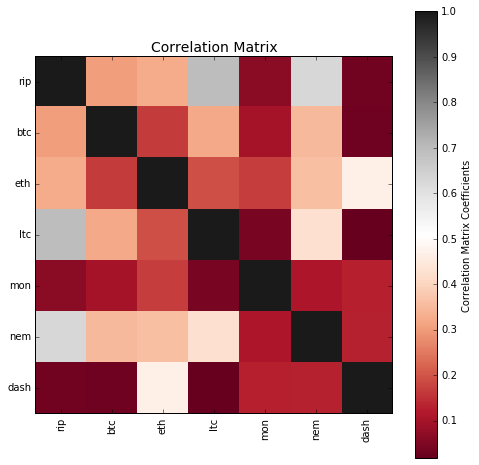

In [27]:
small_df_std = cryp_std
small_df = cryp_unadj
cov = np.cov(cryp_std.values.T) 
corr = np.corrcoef(cryp_unadj.values.T)
eig_vals, eig_vecs = np.linalg.eig(cov)
tickers = list(small_df_std.columns)

# Graph - Correlation matrix
plt.figure(figsize=(8,8))
plt.imshow(corr, cmap="RdGy", interpolation="nearest")
cb = plt.colorbar()
cb.set_label("Correlation Matrix Coefficients")
plt.title("Correlation Matrix", fontsize=14)
plt.xticks(np.arange(len(tickers)), tickers, rotation=90)
plt.yticks(np.arange(len(tickers)), tickers);

### Principal components

In [24]:
# Get SVD breakdown, cast into matrices.
U, s, V = np.linalg.svd(Xcryp)
print(V)
U = np.matrix(U)  # n x n matrix
S = np.zeros((n, p)) 
S[:p, :p] = np.diag(s)
S = np.matrix(S)  # n x p matrix
V = np.matrix(V).T  # p x p matrix

# Get eigenvalues through the singular values.
eigvals_cryp = [(s_**2)/(n - 1) for s_ in s]


[[ 0.517  0.334  0.358  0.455  0.137  0.487  0.174]
 [-0.237 -0.15   0.508 -0.309  0.327 -0.063  0.676]
 [ 0.105 -0.305  0.204  0.065 -0.88   0.037  0.274]
 [-0.286  0.867  0.007 -0.226 -0.311 -0.044  0.13 ]
 [ 0.015  0.095 -0.228  0.611  0.056 -0.64   0.39 ]
 [-0.013 -0.064 -0.712 -0.087  0.027  0.472  0.508]
 [-0.764 -0.091  0.118  0.511 -0.012  0.351 -0.103]]


In [25]:
# Get principal components (n-by-p matrix).
XV = Xcryp*V

pc1, pc2 = np.ravel(XV[:, 0]), np.ravel(XV[:, 1])
v1, v2 = np.ravel(V[:, 0]), np.ravel(V[:, 1])

assert_almost_equal(np.inner(v1, v2), 0)
assert_almost_equal(np.inner(pc1, pc2), 0)

In [26]:
# Create tables for proportion of variation explained.
df_variation_cryp = create_proportion_of_variation_df(eigvals_cryp)
print('Variation Explained:')
display(df_variation_cryp)

Variation Explained:


,eigenvalue,proportion,cumulative
component,,,
1,2.657,0.379,0.379
2,1.376,0.196,0.575
3,0.941,0.134,0.710
4,0.769,0.110,0.819
5,0.564,0.080,0.900
6,0.464,0.066,0.966
7,0.239,0.034,1.000


### Sorting Eigenpairs

In [28]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
eig_vals_list = []
print('Eigenvalues in descending order:')
for i in eig_pairs:
    eig_vals_list.append(i[0])
    print(i[0])

Eigenvalues in descending order:
2.65737779708
1.37619392257
0.940706252426
0.768685386996
0.563511980205
0.463503551823
0.238848347233


In [29]:
eig_pairs

[(2.6573777970786576,
  array([ 0.517,  0.334,  0.358,  0.455,  0.137,  0.487,  0.174])),
 (1.3761939225744044,
  array([ 0.237,  0.15 , -0.508,  0.309, -0.327,  0.063, -0.676])),
 (0.94070625242644057,
  array([-0.105,  0.305, -0.204, -0.065,  0.88 , -0.037, -0.274])),
 (0.76868538699591171,
  array([-0.286,  0.867,  0.007, -0.226, -0.311, -0.044,  0.13 ])),
 (0.56351198020471627,
  array([-0.015, -0.095,  0.228, -0.611, -0.056,  0.64 , -0.39 ])),
 (0.46350355182270109,
  array([-0.013, -0.064, -0.712, -0.087,  0.027,  0.472,  0.508])),
 (0.23884834723260515,
  array([ 0.764,  0.091, -0.118, -0.511,  0.012, -0.351,  0.103]))]

In [17]:
matrix_Q = np.hstack((eig_pairs[0][1].reshape(7,1),
                      eig_pairs[1][1].reshape(7,1),
                      eig_pairs[2][1].reshape(7,1),
                      eig_pairs[3][1].reshape(7,1),
                      eig_pairs[4][1].reshape(7,1),
                      eig_pairs[5][1].reshape(7,1),
                      eig_pairs[6][1].reshape(7,1)))
#with desending order of eigen value 
matrix_Q

array([[ 0.517,  0.237, -0.105, -0.286, -0.015, -0.013,  0.764],
       [ 0.334,  0.15 ,  0.305,  0.867, -0.095, -0.064,  0.091],
       [ 0.358, -0.508, -0.204,  0.007,  0.228, -0.712, -0.118],
       [ 0.455,  0.309, -0.065, -0.226, -0.611, -0.087, -0.511],
       [ 0.137, -0.327,  0.88 , -0.311, -0.056,  0.027,  0.012],
       [ 0.487,  0.063, -0.037, -0.044,  0.64 ,  0.472, -0.351],
       [ 0.174, -0.676, -0.274,  0.13 , -0.39 ,  0.508,  0.103]])

### Loadings

Compute loadings A.
Loadings are eigenvectors normalized to respective eigenvalues: A value = V value * sqrt(L value)
Loadings are the covariances between variables and components.

Loadings=Orthonormal Eigenvectors⋅ Square root of (Absolute Eigen values)

In [31]:
eig_vals_sqrt = np.array([np.sqrt(eig_val) for eig_val in eig_vals_list])
ordered_col = (['rip','btc','ltc','mon','nem','dash','eth'])
loadings = pd.DataFrame(np.multiply(matrix_Q, eig_vals_sqrt)).T
loadings.columns = ordered_col
display(loadings)
display(matrix_Q)

,rip,btc,ltc,mon,nem,dash,eth
0,0.844,0.544,0.583,0.742,0.224,0.793,0.284
1,0.278,0.176,-0.596,0.363,-0.383,0.074,-0.793
2,-0.102,0.296,-0.198,-0.063,0.853,-0.036,-0.266
3,-0.250,0.760,0.006,-0.198,-0.273,-0.039,0.114
4,-0.011,-0.071,0.171,-0.459,-0.042,0.481,-0.293
5,-0.009,-0.043,-0.485,-0.059,0.018,0.321,0.346
6,0.373,0.044,-0.058,-0.250,0.006,-0.171,0.051


array([[ 0.517,  0.237, -0.105, -0.286, -0.015, -0.013,  0.764],
       [ 0.334,  0.15 ,  0.305,  0.867, -0.095, -0.064,  0.091],
       [ 0.358, -0.508, -0.204,  0.007,  0.228, -0.712, -0.118],
       [ 0.455,  0.309, -0.065, -0.226, -0.611, -0.087, -0.511],
       [ 0.137, -0.327,  0.88 , -0.311, -0.056,  0.027,  0.012],
       [ 0.487,  0.063, -0.037, -0.044,  0.64 ,  0.472, -0.351],
       [ 0.174, -0.676, -0.274,  0.13 , -0.39 ,  0.508,  0.103]])

In [32]:
sqr_loadings = loadings.applymap(np.square)
sqr_loadings

,rip,btc,ltc,mon,nem,dash,eth
0,7.116e-01,0.296,3.399e-01,0.550,5.002e-02,0.629,0.081
1,7.709e-02,0.031,3.546e-01,0.132,1.469e-01,0.006,0.629
2,1.034e-02,0.087,3.919e-02,0.004,7.279e-01,0.001,0.071
3,6.275e-02,0.578,3.784e-05,0.039,7.427e-02,0.001,0.013
4,1.239e-04,0.005,2.925e-02,0.211,1.757e-03,0.231,0.086
5,7.429e-05,0.002,2.350e-01,0.003,3.313e-04,0.103,0.119
6,1.393e-01,0.002,3.314e-03,0.062,3.500e-05,0.029,0.003


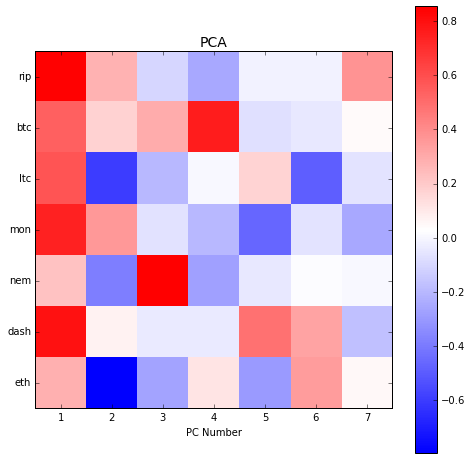

In [33]:
LL = np.multiply(matrix_Q,eig_vals_sqrt)
tickers = ordered_col
ax = plt.figure(figsize=(8,8)).gca()
plt.imshow(LL, cmap="bwr", interpolation="nearest")
cb = plt.colorbar()
plt.yticks(np.arange(len(tickers)), tickers)
plt.xticks(np.arange(len(tickers)), [0,1,2,3,4,5,6,7])
plt.xlabel("PC Number")
plt.title("PCA", fontsize=14)
# force x-tickers to be displayed as integers (not floats)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

### Bi-plot for PC(1) and PC(2)

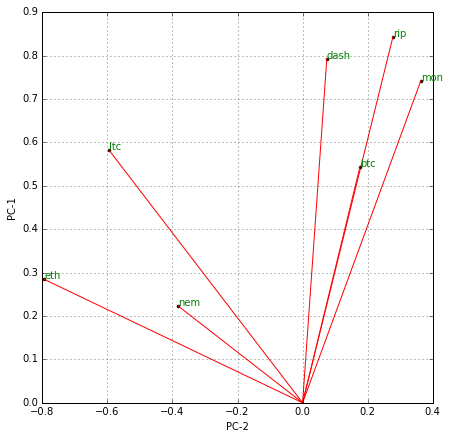

In [22]:
k1 = 1  # the last PC column in 'v' PCA matrix
k2 = 0  # the second last PC column
 
# begin constructing bi-plot for PC(k1) and PC(k2)
# loadings
plt.figure(figsize=(7,7))
plt.grid()
 
# compute the distance from (0,0) point
dist = []
for i in range(LL.shape[0]):
    x = LL[i,k1]
    y = LL[i,k2]
    plt.plot(x, y, '.k')
    plt.plot([0,x], [0,y], '-', color="r")
    d = np.sqrt(x**2 + y**2)
    dist.append(d)
    plt.text(x, y, tickers[i], color='g')
plt.xlabel("PC-" + str(k1+1))
plt.ylabel("PC-" + str(k2+1));

### linear correlations & Kendall’s rank correlation

we examine linear correlations for such pair of coins (cryptocurrency time-series) making use of two distinct tools, namely, one-factor linear regression (hence its $R^2$ metric) and Kendall’s rank correlation metric of τ.

rip ltc
0.693920469872 4.39091861193e-115
0.198414867023 5.89017740411e-17


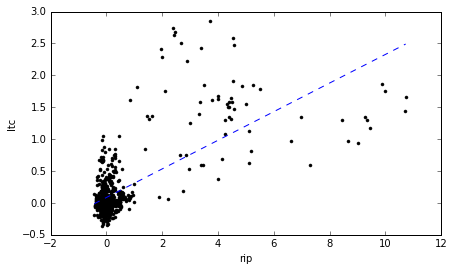

rip nem
0.630201329527 4.11096466073e-89
0.232985037418 8.71419599445e-23


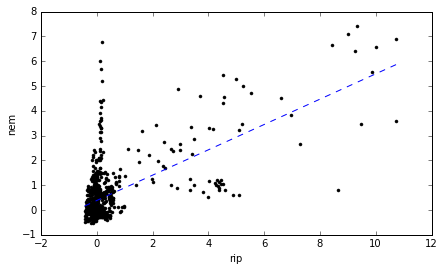

rip eth
0.325414899102 4.84600738271e-21
0.320617112581 1.16422872657e-41


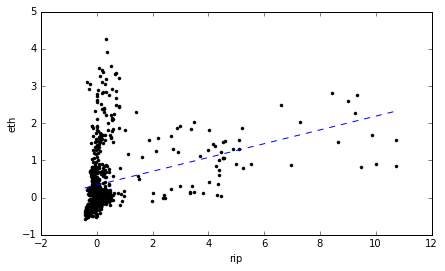

rip rip
1.0 0.0
1.0 0.0


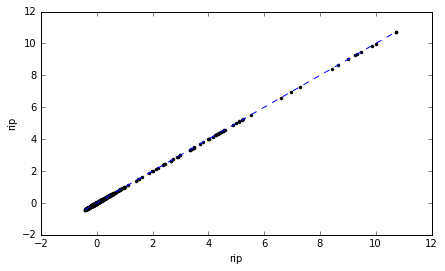

rip btc
0.304642871018 1.63110614216e-18
0.146492768907 6.48398276858e-10


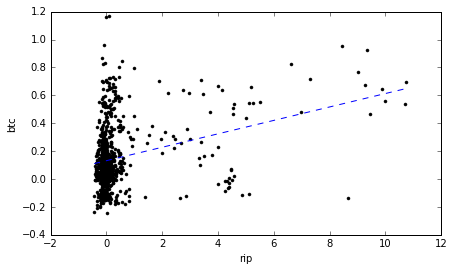

rip mon
0.0661992605033 0.0622557492194
0.23846045115 8.57459340142e-24


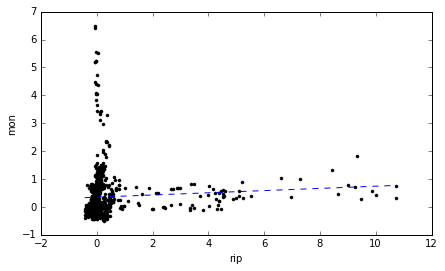

rip dash
0.0369910959304 0.297852589256
0.0769774426307 0.00116860365918


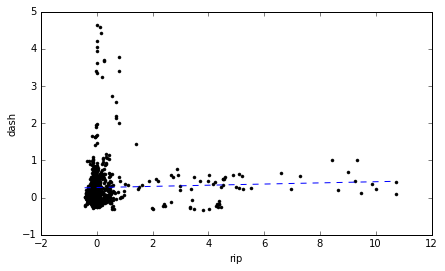

btc ltc
0.322116552411 1.25902464199e-20
0.363567345155 4.66722974816e-53


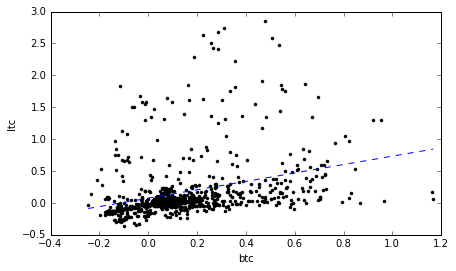

btc nem
0.348594624346 4.21138947176e-24
0.192930212176 4.06592181113e-16


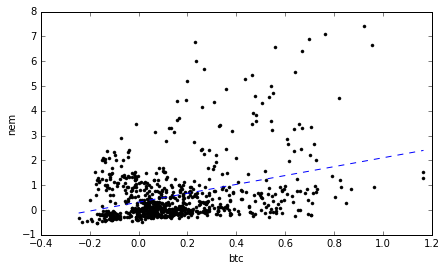

btc eth
0.164432758418 3.19563716189e-06
0.155399417447 5.60830481492e-11


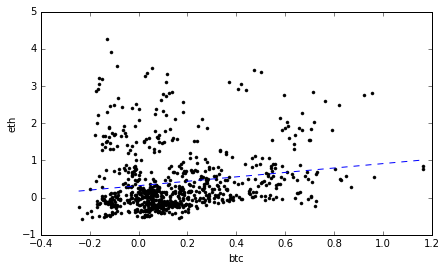

btc rip
0.304642871018 1.63110614216e-18
0.146492768907 6.48398276858e-10


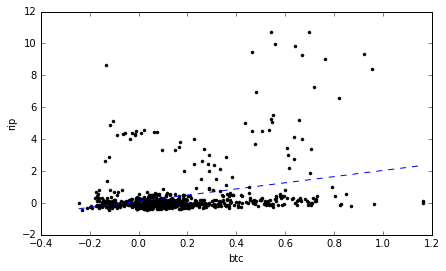

btc btc
1.0 0.0
1.0 0.0


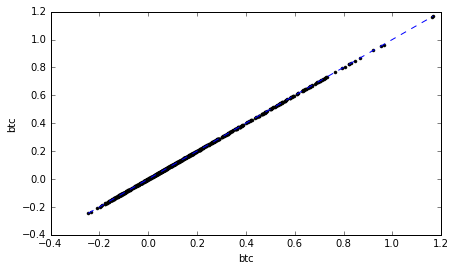

btc mon
0.101504493979 0.00419536829015
0.159043515413 1.98019555307e-11


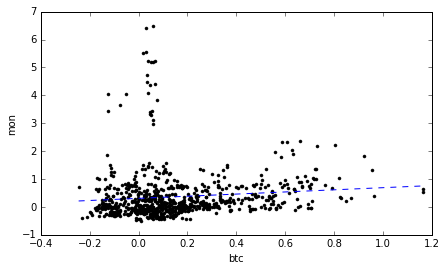

btc dash
0.0310693405203 0.381952795708
0.00609237991936 0.797225815462


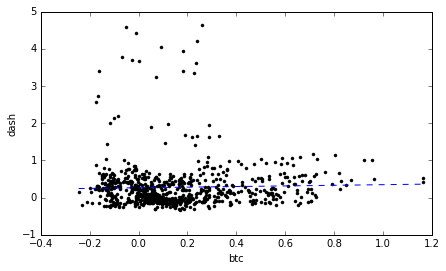

ltc ltc
1.0 0.0
1.0 0.0


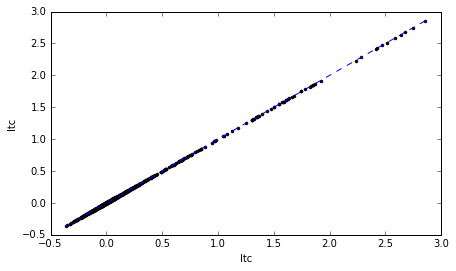

ltc nem
0.427824289529 1.12622050038e-36
0.121411383718 3.0548761128e-07


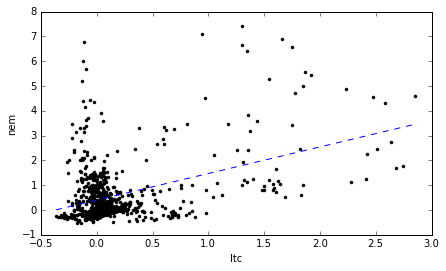

ltc eth
0.191742670476 5.18014140415e-08
0.19790025457 7.07923757781e-17


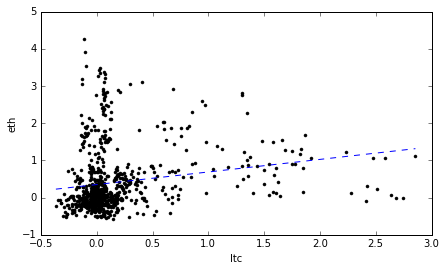

mon ltc
0.0435716691798 0.220044075964
0.133418679189 1.84002822158e-08


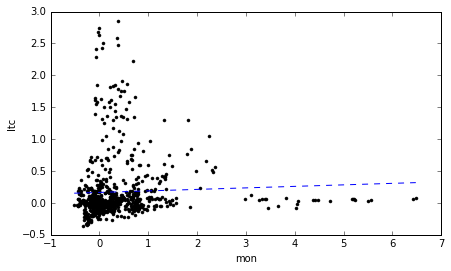

mon nem
0.113523043053 0.00135449214406
0.286055073266 1.63745331684e-33


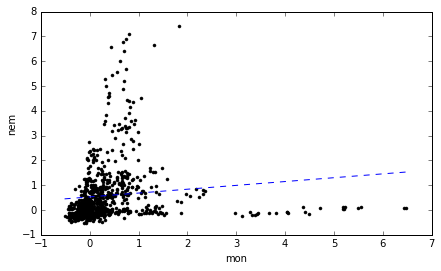

mon eth
0.171495476374 1.168870526e-06
0.317248455071 7.95894637539e-41


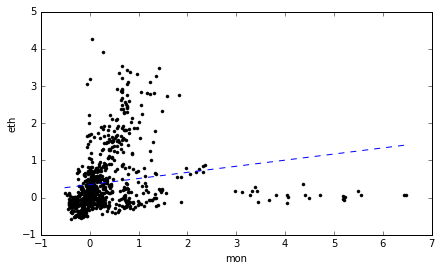

mon rip
0.0661992605033 0.0622557492194
0.23846045115 8.57459340142e-24


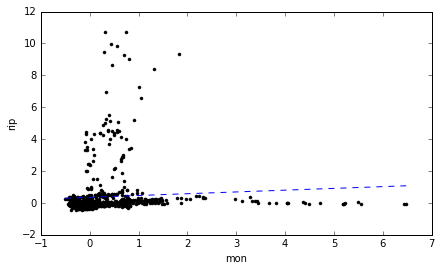

mon btc
0.101504493979 0.00419536829015
0.159043515413 1.98019555307e-11


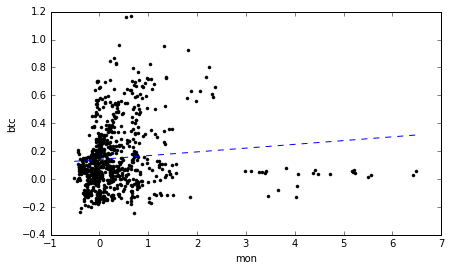

mon mon
1.0 0.0
1.0 0.0


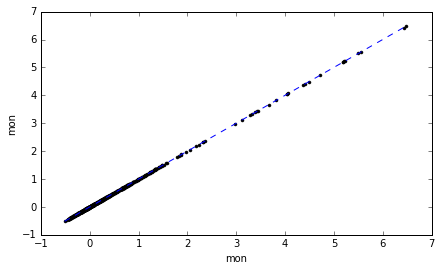

mon dash
0.128492368452 0.000283408007145
0.313892471206 5.29479607339e-40


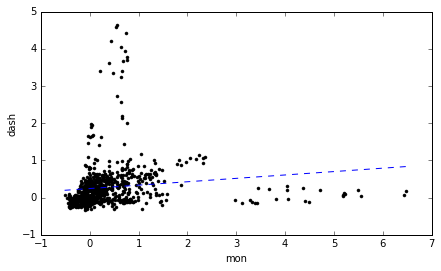

nem ltc
0.427824289529 1.12622050038e-36
0.121411383718 3.0548761128e-07


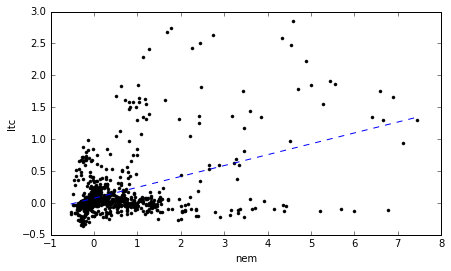

nem nem
1.0 0.0
1.0 0.0


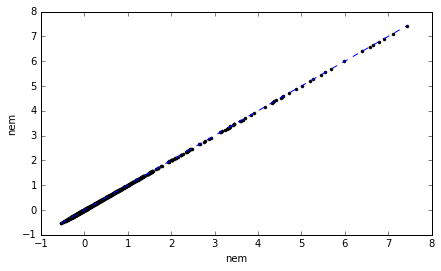

nem eth
0.360734970194 8.23472391248e-26
0.311792350205 1.71440637015e-39


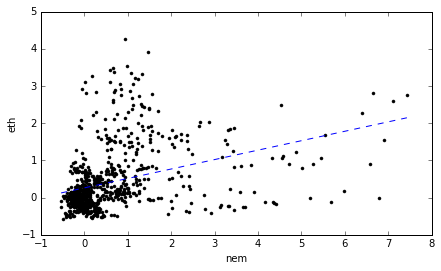

dash ltc
0.0182270927029 0.608065647679
0.0816204653113 0.000577385590558


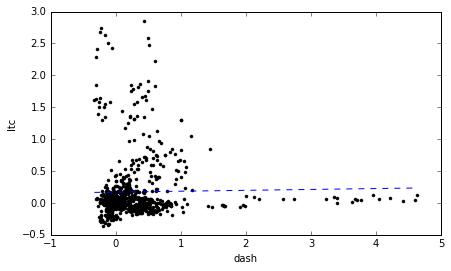

dash nem
0.133001751741 0.000170914758669
0.236775650617 1.76125405834e-23


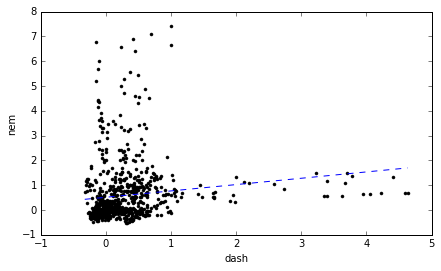

dash eth
0.470272520014 6.20184921e-45
0.368122050894 2.34561823627e-54


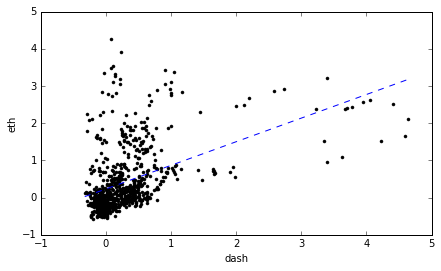

dash rip
0.0369910959304 0.297852589256
0.0769774426307 0.00116860365918


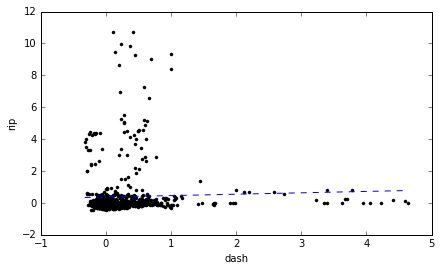

dash btc
0.0310693405203 0.381952795708
0.00609237991936 0.797225815462


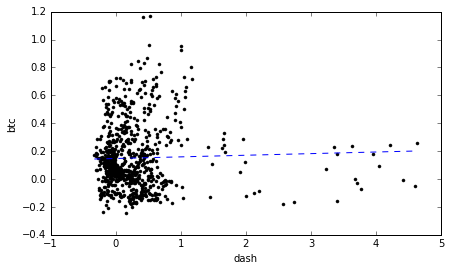

dash mon
0.128492368452 0.000283408007145
0.313892471206 5.29479607339e-40


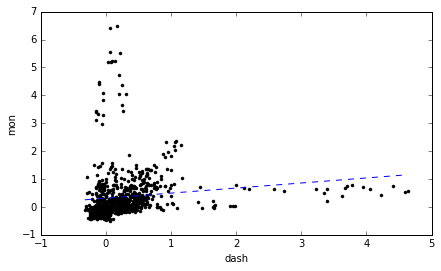

dash dash
1.0 0.0
1.0 0.0


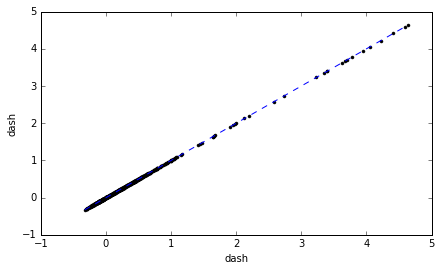

eth ltc
0.191742670476 5.18014140415e-08
0.19790025457 7.07923757781e-17


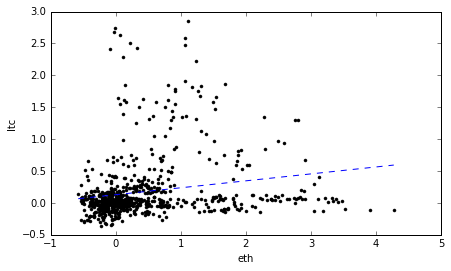

eth nem
0.360734970194 8.23472391248e-26
0.311792350205 1.71440637015e-39


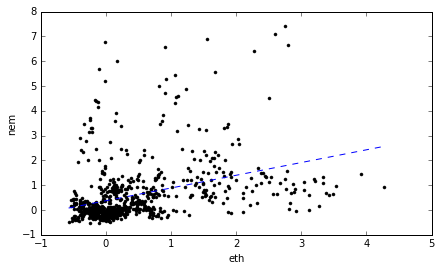

eth eth
1.0 0.0
1.0 0.0


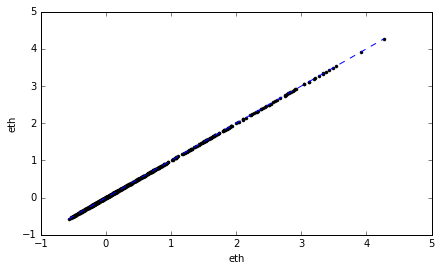

In [23]:
quar = []
for i in range(matrix_Q.shape[0]):
    x = matrix_Q[i,k1]
    y = matrix_Q[i,k2]
    
    d = np.sqrt(x**2 + y**2)
    if(d > 0):
        if((x > 0) and (y > 0)):
            quar.append((i, 1))
        elif((x < 0) and (y > 0)):
            quar.append((i, 2))
        elif((x < 0) and (y < 0)):
            quar.append((i, 3))
        elif((x > 0) and (y < 0)):
            quar.append((i, 4))
import scipy.stats as stats
for i in range(len(quar)):
    if(quar[i][1] == 1):
        for j in range(len(quar)):
            if(quar[j][1] == 2):
                plt.figure(figsize=(7,4))
 
                # highly correlated coins according to the PC analysis
                print(tickers[quar[i][0]], tickers[quar[j][0]])
 
                ts1 = small_df[tickers[quar[i][0]]]  # time-series
                ts2 = small_df[tickers[quar[j][0]]]
 
                # correlation metrics and their p_values
                slope, intercept, r2, pvalue, _ = stats.linregress(ts1, ts2)
                ktau, kpvalue = stats.kendalltau(ts1, ts2)
                print(r2, pvalue)
                print(ktau, kpvalue)
 
                plt.plot(ts1, ts2, '.k')
                xline = np.linspace(np.min(ts1), np.max(ts1), 100)
                yline = slope*xline + intercept
                plt.plot(xline, yline,'--', color='b')  # linear model fit
                plt.xlabel(tickers[quar[i][0]])
                plt.ylabel(tickers[quar[j][0]])
                plt.show()

    if(quar[i][1] == 1):
        for j in range(len(quar)):
            if(quar[j][1] == 1):
                plt.figure(figsize=(7,4))
                print(tickers[quar[i][0]], tickers[quar[j][0]])
                ts1 = small_df[tickers[quar[i][0]]]
                ts2 = small_df[tickers[quar[j][0]]]
                slope, intercept, r2, pvalue, _ = stats.linregress(ts1, ts2)
                ktau, kpvalue = stats.kendalltau(ts1, ts2)
                print(r2, pvalue)
                print(ktau, kpvalue)
                plt.plot(ts1, ts2, '.k')
                xline = np.linspace(np.min(ts1), np.max(ts1), 100)
                yline = slope*xline + intercept
                plt.plot(xline, yline,'--', color='b')
                plt.xlabel(tickers[quar[i][0]])
                plt.ylabel(tickers[quar[j][0]])
                plt.show()

    if(quar[i][1] == 2):
        for j in range(len(quar)):
            if(quar[j][1] == 2):
                plt.figure(figsize=(7,4))
                print(tickers[quar[i][0]], tickers[quar[j][0]])
                ts1 = small_df[tickers[quar[i][0]]]
                ts2 = small_df[tickers[quar[j][0]]]
                slope, intercept, r2, pvalue, _ = stats.linregress(ts1, ts2)
                ktau, kpvalue = stats.kendalltau(ts1, ts2)
                print(r2, pvalue)
                print(ktau, kpvalue)
                plt.plot(ts1, ts2, '.k')
                xline = np.linspace(np.min(ts1), np.max(ts1), 100)
                yline = slope*xline + intercept
                plt.plot(xline, yline,'--', color='b')
                plt.xlabel(tickers[quar[i][0]])
                plt.ylabel(tickers[quar[j][0]])
                plt.show()

# Are cryptocurrencies an asset class?

## Get data for energy (XLE)

In [54]:
XLE_df, XLE_df_std, X_xle = load_xle_returns(XLE_FILES)

# Filter to same time frame as cryptocurrencies.
XLE_df = XLE_df[XLE_df.index >= analysis_start_dt]
XLE_df = XLE_df[XLE_df.index <= analysis_end_dt]

XLE_df_std = XLE_df_std[XLE_df_std.index >= analysis_start_dt]
XLE_df_std = XLE_df_std[XLE_df_std.index <= analysis_end_dt]
X_xle = np.matrix(XLE_df_std.values)

n, p = X_xle.shape
C = np.cov(X_xle, rowvar=False)  # covariance matrix
assert n == len(XLE_df_std.index)
print('Number of returns in data: {}'.format(n))

Number of returns in data: 284


### Compute SVD components & loadings

In [55]:
# Get SVD breakdown, cast into matrices.
U, s, V = np.linalg.svd(X_xle)
U = np.matrix(U)  # n x n matrix
S = np.zeros((n, p)) 
S[:p, :p] = np.diag(s)
S = np.matrix(S)  # n x p matrix
V = np.matrix(V).T  # p x p matrix eigenvectors

# Get eigenvalues through the singular values.
eigvals_xle = [(s_**2)/(n - 1) for s_ in s]

# Create tables for proportion of variation and eigenvectors.
df_variation_xle = create_proportion_of_variation_df(eigvals_xle)
print('Variation Explained:')
display(df_variation_xle.round(3))

# Create loadings DataFrame.
idx = pd.Series([i + 1 for i in range(p)], name='Component')
loadings_xle = pd.DataFrame(np.multiply(V, 
                                        np.sqrt(np.abs(eigvals_xle))).T,
                           columns=XLE_df_std.columns,
                           index=idx)
print('\nLoadings:')
display(loadings_xle.round(3))

Variation Explained:


,eigenvalue,proportion,cumulative
component,,,
1,5.141,0.661,0.661
2,0.966,0.124,0.786
3,0.664,0.085,0.871
4,0.429,0.055,0.926
5,0.230,0.030,0.956
6,0.203,0.026,0.982
7,0.139,0.018,1.000



Loadings:


,COP,CVX,EOG,OXY,PSX,SLB,XOM
Component,,,,,,,
1,0.997,0.971,0.885,0.860,0.532,0.806,0.866
2,0.667,0.014,0.102,-0.375,0.285,-0.209,-0.496
3,-0.175,-0.403,0.323,0.181,0.217,0.397,-0.359
4,0.203,-0.058,0.155,0.132,-0.569,0.031,-0.137
5,-0.005,-0.148,0.197,0.177,0.068,-0.355,0.084
6,-0.173,0.167,0.299,-0.229,-0.050,-0.027,-0.010
7,0.089,-0.214,0.045,-0.177,-0.023,0.072,0.214


### Proportion z-test

In [56]:
def count_same_sign(df_load, crypto_pair, n_comp):
    """Returns number of times loadings are of the same sign for pair of 
    cryptocurrencies among n_comp components.
    """
    same_sign = 0
    crypt1, crypt2 = crypto_pair
    for i in range(1, n_comp + 1):
        loadings = [df_load.loc[i][crypt1], df_load.loc[i][crypt2]]
        signs = [int(s) for s in np.sign(loadings)]
        if abs(sum(signs)) == 2:
            same_sign += 1
    return same_sign

In [57]:
# Prepare DataFrame storing number of times the loadings for a pair of 
# assets have the same signs for a certain number of PCs.

ss_n_comp_cryp = 3
ss_n_comp_xle = 3

# First prepare for cryptos.
cryp_pairs = list(combinations(loadings_cryp.columns, 2))
cryp_rows = []
for pair in cryp_pairs:
    count = count_same_sign(loadings_cryp, pair, n_comp=ss_n_comp_cryp)
    cryp_rows.append([pair[0], pair[1], count])

cols = ['Crypto 1', 'Crypto 2', 'Same Sign Loading']
cryp_ss_df = pd.DataFrame(cryp_rows, columns=cols)
display(cryp_ss_df)

# Prepare for energy.
xle_pairs = list(combinations(loadings_xle.columns, 2))
xle_rows = []
for pair in xle_pairs:
    count = count_same_sign(loadings_xle, pair, n_comp=ss_n_comp_xle)
    xle_rows.append([pair[0], pair[1], count])

cols = ['Stock 1', 'Stock 2', 'Same Sign Loading']
xle_ss_df = pd.DataFrame(xle_rows, columns=cols)
display(xle_ss_df)

,Crypto 1,Crypto 2,Same Sign Loading
0,rip,btc,2
1,rip,eth,2
2,rip,ltc,3
3,rip,mon,1
4,rip,nem,3
5,rip,dash,2
6,btc,eth,1
7,btc,ltc,2
8,btc,mon,2
9,btc,nem,2


,Stock 1,Stock 2,Same Sign Loading
0,COP,CVX,3
1,COP,EOG,2
2,COP,OXY,1
3,COP,PSX,2
4,COP,SLB,1
5,COP,XOM,2
6,CVX,EOG,2
7,CVX,OXY,1
8,CVX,PSX,2
9,CVX,SLB,1


In [58]:
# Perform proportion z-test using proportion of times the crypto pair 
# had the same loading signs.

def perform_proportion_ztest(ss_df, ncomp, null_hypo_value = 0.5):
    """Performs proportion z-test on DF containing number of same-sign pairs."""    
    ss_counts = ss_df['Same Sign Loading'].tolist()
    total_same_sign = sum(ss_counts)
    total_obs = ncomp * len(ss_df.index)
    return proportions_ztest(total_same_sign, 
                             nobs=total_obs, 
                             value=null_hypo_value,
                             alternative='two-sided', 
                             prop_var=null_hypo_value)
    
print('Crypto proportion z-test:')
zstat, pval = perform_proportion_ztest(cryp_ss_df, ss_n_comp_cryp)
print('z-stat: {:.3f}\np-value: {:.4%}'.format(zstat, pval))

print('\nXLE proportion z-test:')
zstat, pval = perform_proportion_ztest(xle_ss_df, ss_n_comp_xle)
print('z-stat: {:.3f}\np-value: {:.4%}'.format(zstat, pval))

Crypto proportion z-test:
z-stat: 2.394
p-value: 1.6676%

XLE proportion z-test:
z-stat: 1.890
p-value: 5.8782%


In [59]:
def save_string(filename, s):
    if filename[-4:] != '.txt': filename += '.txt'
    with open(filename, "w") as text_file:
        text_file.write(s)

In [60]:
save_string('cryp loadings', loadings_cryp.round(3).to_latex())

### Inter-temporal consistency of covariance matrix

In [61]:
# Split crypto DF into two time periods.

tmid = int(len(cryp_std.index)/2)
cryp_t1 = cryp_std.iloc[0:tmid]
cryp_t2 = cryp_std.iloc[tmid:]
print('Time frame 1: {}-{}'.format(min(cryp_t1.index), max(cryp_t1.index)))
print('Time frame 2: {}-{}'.format(min(cryp_t2.index), max(cryp_t2.index)))

Time frame 1: 2015-09-06 00:00:00-2016-10-06 00:00:00
Time frame 2: 2016-10-07 00:00:00-2017-11-07 00:00:00


In [62]:
# Prepare proportion of variation and loadings DF for both time periods.

def get_loadings(X, colnames):
    """Returns proportion of variation DF and loadings DF."""
    # Get SVD breakdown, cast into matrices.
    n, p = X.shape
    U, s, V = np.linalg.svd(X)
    U = np.matrix(U)  # n x n matrix
    S = np.zeros((n, p)) 
    S[:p, :p] = np.diag(s)
    S = np.matrix(S)  # n x p matrix
    V = np.matrix(V).T  # p x p matrix eigenvectors
    
    # Get eigenvalues through the singular values.
    eigvals = [(s_**2)/(n - 1) for s_ in s]

    # Create DF for proportion of variation.
    df_variation = create_proportion_of_variation_df(eigvals)
    
    # Create loadings DataFrame.
    idx = pd.Series([i + 1 for i in range(p)], name='Component')
    df_loadings = pd.DataFrame(np.multiply(V, 
                                        np.sqrt(np.abs(eigvals))).T,
                               columns=colnames,
                               index=idx)
    return df_variation, df_loadings

variation_t1, loadings_t1 = get_loadings(cryp_t1.values, cryp_std.columns)
variation_t2, loadings_t2 = get_loadings(cryp_t2.values, cryp_std.columns)

In [63]:
print('Variation in T1:')
display(variation_t1)
print('\nVariation in T2:')
display(variation_t2)

Variation in T1:


,eigenvalue,proportion,cumulative
component,,,
1,1.665,0.360,0.360
2,1.079,0.233,0.594
3,0.843,0.182,0.776
4,0.684,0.148,0.924
5,0.247,0.054,0.978
6,0.071,0.015,0.993
7,0.032,0.007,1.000



Variation in T2:


,eigenvalue,proportion,cumulative
component,,,
1,4.600,0.489,0.489
2,2.265,0.241,0.729
3,1.164,0.124,0.853
4,0.628,0.067,0.920
5,0.296,0.031,0.951
6,0.241,0.026,0.977
7,0.220,0.023,1.000


In [64]:
print('Loadings in T1:')
display(loadings_t1.round(3))
print('\nLoadings in T2:')
display(loadings_t2.round(3))

Loadings in T1:


,rip,btc,eth,ltc,mon,nem,dash
Component,,,,,,,
1,-0.001,0.059,-0.165,0.028,-1.276,-0.072,0.003
2,0.088,0.031,0.926,0.031,-0.141,0.424,0.110
3,0.117,0.716,-0.236,0.258,0.045,0.438,-0.017
4,0.097,0.358,0.258,0.275,0.025,-0.634,0.044
5,0.132,-0.102,-0.076,0.140,0.008,0.024,0.440
6,0.179,-0.092,-0.012,0.127,-0.001,0.017,-0.118
7,0.119,0.036,-0.002,-0.127,0.000,-0.016,0.014



Loadings in T2:


,rip,btc,eth,ltc,mon,nem,dash
Component,,,,,,,
1,1.244,0.608,0.627,1.075,0.207,0.995,0.320
2,-0.324,0.062,0.625,-0.419,0.225,-0.021,1.241
3,0.180,-0.952,-0.005,0.368,-0.146,-0.088,0.246
4,-0.378,0.204,-0.121,0.583,0.057,-0.260,0.134
5,0.066,0.093,-0.360,-0.039,-0.289,0.115,0.235
6,-0.163,-0.099,-0.175,0.003,0.278,0.312,0.006
7,0.228,0.027,-0.184,-0.044,0.275,-0.222,0.083


#### Regression model from time period 1 to time period 2

More appropriate to use no-intercept model?

In [65]:
dft1 = pd.DataFrame()
dft1['t1load'] = np.ravel(loadings_t1.iloc[0:3].values)
dft1['intercept'] = 1

Y = np.ravel(loadings_t2.iloc[0:3].values)

model = sm.OLS(Y, dft1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.4951
Date:                Thu, 14 Dec 2017   Prob (F-statistic):              0.490
Time:                        12:01:02   Log-Likelihood:                -16.843
No. Observations:                  21   AIC:                             37.69
Df Residuals:                      19   BIC:                             39.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
t1load        -0.2134      0.303     -0.704      0.490        -0.848     0.421
intercept      0.3029      0.125      2.416      0.026         0.041     0.565
==============================================================================
Omnibus:                        0.233   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.890   Jarque-Bera (JB):                0.414
Skew:                           0.163   Prob(JB):                        0.813
Kurtosis:                       2.393   Cond. No.                         2.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""